### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

### Dataset

In [3]:
xray_df = pd.read_csv(r'D:\Git Clones\CPE-313\xray\Data_Entry_2017.csv')
image_path = {os.path.basename(x): x for x in
              glob(os.path.join('xray', 'images*', '*', '*.png'))}
print('Scans found:', len(image_path), ', Total Headers', xray_df.shape[0])
xray_df['path'] = xray_df['Image Index'].map(image_path.get)

Scans found: 112120 , Total Headers 112120


In [4]:
xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,xray\images_001\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,xray\images_001\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,xray\images_001\images\00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,xray\images_001\images\00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,xray\images_001\images\00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,xray\images_012\images\00030801_001.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,xray\images_012\images\00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,xray\images_012\images\00030803_000.png
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,xray\images_012\images\00030804_000.png


In [5]:
xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path'],
      dtype='object')

In [6]:
xray_df.dtypes

Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
Unnamed: 11                    float64
path                            object
dtype: object

### Pre Processing

In [7]:
from itertools import chain

all_labels = np.unique(list(chain(*xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
109582,00029813_032.png,Effusion,32,29813,66,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111462,00030495_000.png,No Finding,0,30495,5,F,AP,2544,3056,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47915,00012144_018.png,Pneumothorax,18,12144,21,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


> The target feature (Finding Labels) has more than 1 value. By performing one hat encoding, I created a new columns for each of the value of Finding Labels and then put its value either 0 or 1 depending if that image has the said finding.

### Splitting

In [8]:
train_df, test_df = train_test_split(xray_df, 
                                   test_size = 0.2, 
                                   random_state = 42,
                                   stratify = xray_df['Finding Labels'].map(lambda x: x[:4]))

In [9]:
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 89696 test 22424


In [10]:
train_df['NewFindings'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['NewFindings'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [11]:
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,NewFindings
40987,00010613_009.png,No Finding,9,10613,56,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
3919,00001075_019.png,No Finding,19,1075,59,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
67987,00016789_012.png,Infiltration,12,16789,35,M,PA,2478,2765,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,[Infiltration]
34361,00009025_000.png,No Finding,0,9025,43,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
90420,00022493_002.png,Nodule|Pleural_Thickening,2,22493,34,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,"[Nodule, Pleural_Thickening]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36305,00009589_006.png,No Finding,6,9589,47,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
94804,00024530_000.png,No Finding,0,24530,43,F,PA,3056,2512,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
56060,00013993_116.png,Atelectasis|Effusion,116,13993,43,M,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Atelectasis, Effusion]"
108797,00029526_004.png,No Finding,4,29526,34,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]


In [12]:
test_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,NewFindings
80364,00019750_020.png,Infiltration,20,19750,61,M,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,[Infiltration]
104835,00028099_000.png,No Finding,0,28099,16,M,PA,2544,3056,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
58828,00014558_013.png,No Finding,13,14558,35,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
34541,00009098_002.png,No Finding,2,9098,55,M,AP,3056,2528,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
51261,00012947_001.png,No Finding,1,12947,45,F,PA,2544,3056,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,00004726_000.png,No Finding,0,4726,48,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
56608,00014083_001.png,Infiltration,1,14083,23,F,AP,2500,2048,0.168000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,[Infiltration]
10279,00002666_003.png,No Finding,3,2666,38,M,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
91329,00022788_001.png,No Finding,1,22788,40,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]


In [13]:
xray_df.columns[-14:]

Index(['Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

### Create Data Generators

In [16]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
IDG = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [20]:
train_generation = IDG.flow_from_dataframe(train_df, directory=None, 
                                           x_col = 'path', 
                                           y_col = 'NewFindings', 
                                           class_mode = 'categorical', 
                                           classes = all_labels, 
                                           target_size = (224, 224), 
                                           color_mode = 'grayscale', 
                                           batch_size = 32)

test_generation = IDG.flow_from_dataframe(test_df, directory=None, 
                                           x_col = 'path', 
                                           y_col = 'NewFindings', 
                                           class_mode = 'categorical', 
                                           classes = all_labels, 
                                           target_size = (224, 224), 
                                           color_mode = 'grayscale', 
                                           batch_size = 128)

test_X, test_Y = next(IDG.flow_from_dataframe(test_df, directory=None, 
                                              x_col = 'path', 
                                              y_col = 'NewFindings',
                                              class_mode = 'categorical', 
                                              classes = all_labels, 
                                              target_size = (224,224),
                                              color_mode = 'grayscale', 
                                              batch_size = 1024))

Found 89696 validated image filenames belonging to 15 classes.
Found 22424 validated image filenames belonging to 15 classes.
Found 22424 validated image filenames belonging to 15 classes.


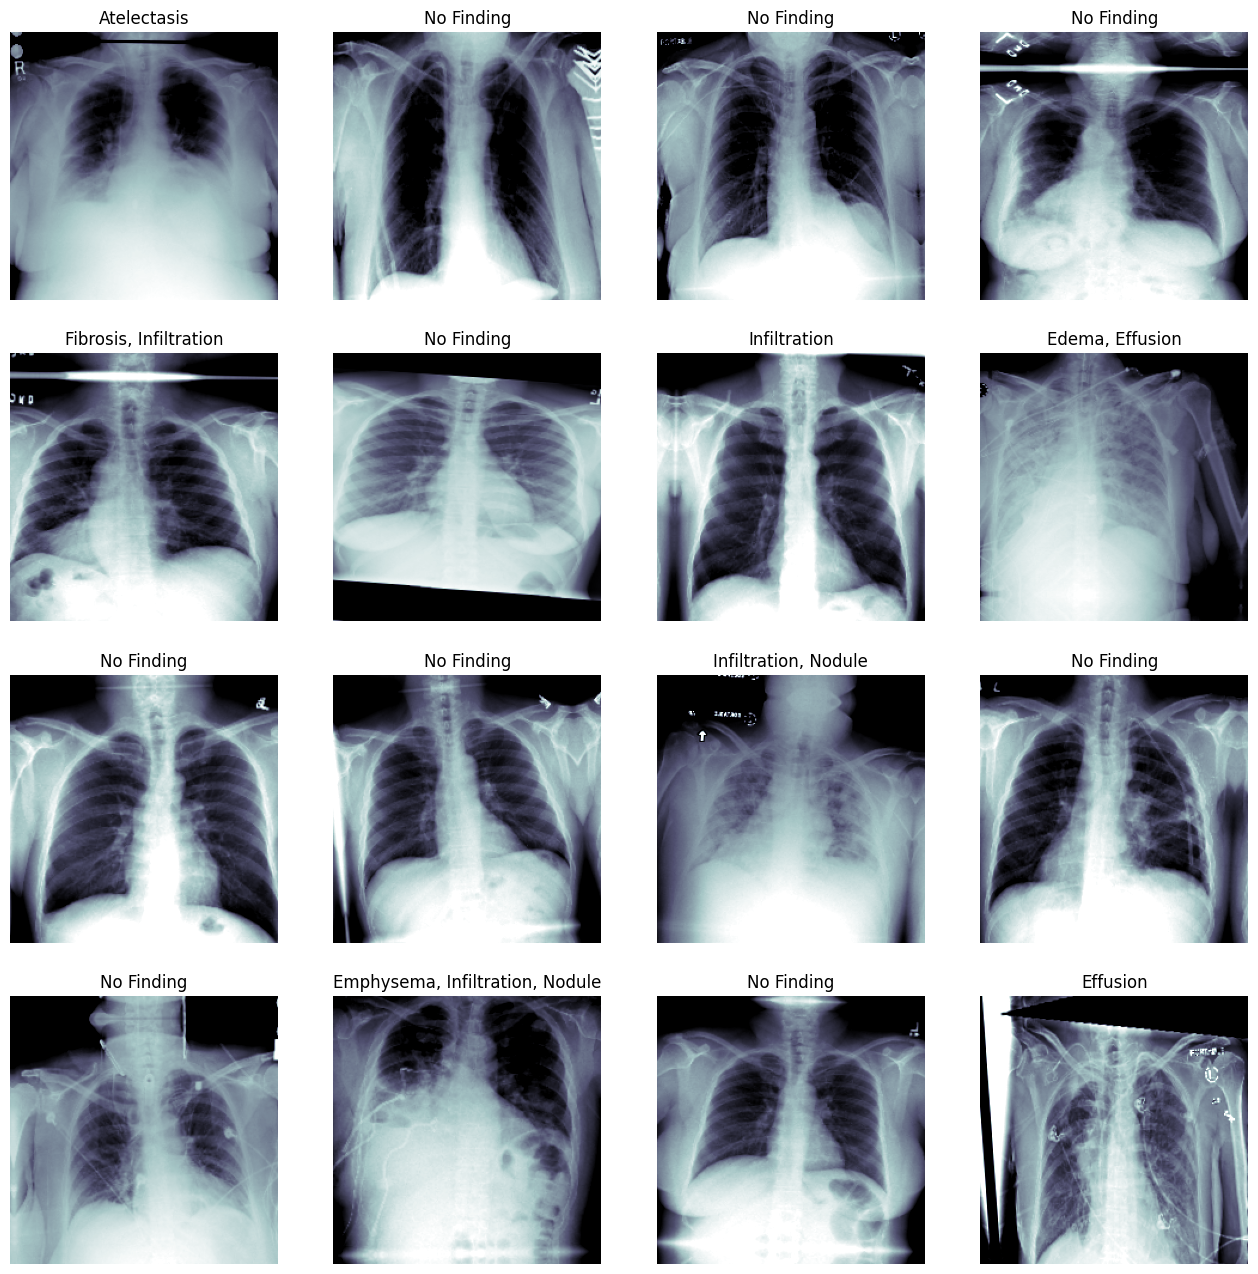

In [21]:
x_train, y_train = next(train_generation)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(x_train, y_train, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

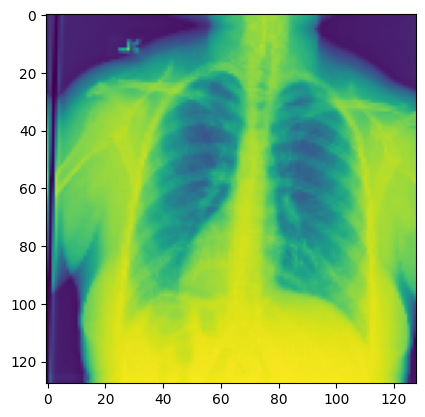

In [86]:
plt.imshow(test_X[13])

### Building CNN from scratch

In [23]:
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D,GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization

In [24]:
model = Sequential()


model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(all_labels), activation = 'sigmoid'))

In [25]:
model.compile(loss='binary_crossentropy',
               optimizer = 'adam',
               metrics=['binary_accuracy'])

hist_1 = model.fit(train_generation, verbose = 1, epochs=10, steps_per_epoch = 50, validation_data = (test_X, test_Y))

Epoch 1/10
50/50 [==============================] - 135s 2s/step - loss: 0.3284 - binary_accuracy: 0.8786 - val_loss: 0.3896 - val_binary_accuracy: 0.9249
Epoch 2/10
50/50 [==============================] - 104s 2s/step - loss: 0.2581 - binary_accuracy: 0.9151 - val_loss: 0.3007 - val_binary_accuracy: 0.9264
Epoch 3/10
50/50 [==============================] - 87s 2s/step - loss: 0.2493 - binary_accuracy: 0.9160 - val_loss: 0.2726 - val_binary_accuracy: 0.9267
Epoch 4/10
50/50 [==============================] - 88s 2s/step - loss: 0.2343 - binary_accuracy: 0.9212 - val_loss: 0.2968 - val_binary_accuracy: 0.9227
Epoch 5/10
50/50 [==============================] - 100s 2s/step - loss: 0.2391 - binary_accuracy: 0.9173 - val_loss: 0.2597 - val_binary_accuracy: 0.9243
Epoch 6/10
50/50 [==============================] - 89s 2s/step - loss: 0.2450 - binary_accuracy: 0.9176 - val_loss: 0.2408 - val_binary_accuracy: 0.9238
Epoch 7/10
50/50 [==============================] - 93s 2s/step - loss: 0

> Based on the result, the model is learning as the epoch increases. It has a pretty good acurray to validation accuracy ratio.

In [26]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 9.67%
Cardiomegaly: 2.54%
Consolidation: 4.98%
Edema: 2.05%
Effusion: 10.84%
Emphysema: 1.66%
Fibrosis: 1.86%
Hernia: 0.39%
Infiltration: 17.87%
Mass: 5.57%
No Finding: 53.32%
Nodule: 6.05%
Pleural_Thickening: 2.15%
Pneumonia: 1.66%
Pneumothorax: 4.88%


In [29]:
pred_Y = model.predict(test_X, batch_size = 32, verbose = True)

32/32 [==============================] - 2s 57ms/step


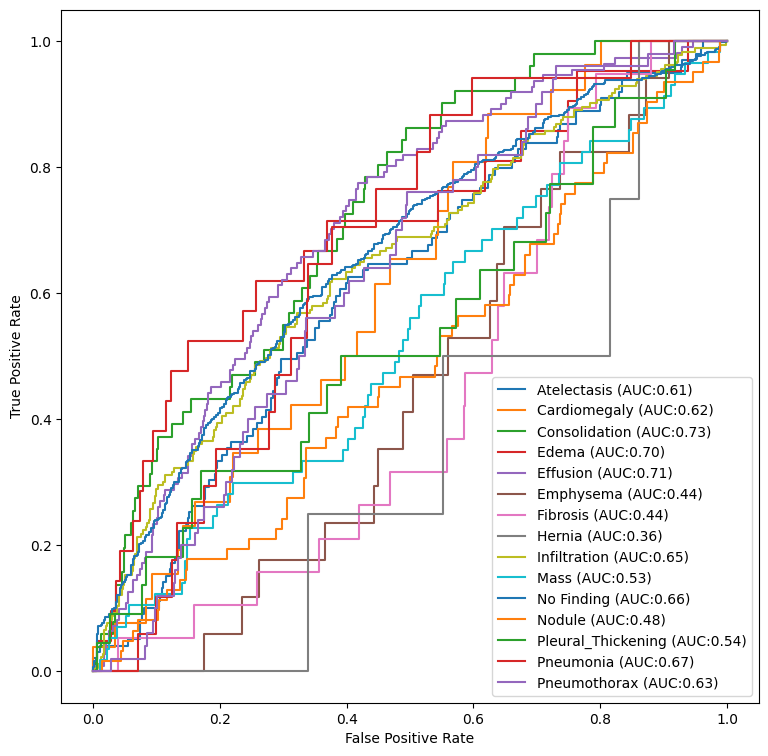

In [30]:
# ROC CURVE

from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

### Pre trained Model

In [31]:
# DenseNet201

from keras.applications import densenet
from keras.models import Model

densenet_model = densenet.DenseNet201(input_shape = x_train.shape[1:],
                                      include_top = False,
                                      weights = None)
for layer in densenet_model.layers:
    layer.trainable = False # freezing

x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(len(all_labels), activation = 'sigmoid')(x)

densenetv2_model = Model(inputs = densenet_model.input,
                         outputs = predictions)

densenetv2_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  3136        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [32]:
densenetv2_model.compile(loss='binary_crossentropy',
               optimizer = 'adam',
               metrics=['binary_accuracy'])

hist_2 = densenetv2_model.fit(train_generation, verbose = 1, epochs=10, steps_per_epoch = 50, validation_data = (test_X, test_Y))

Epoch 1/10
50/50 [==============================] - 96s 2s/step - loss: 0.3098 - binary_accuracy: 0.9116 - val_loss: 0.2199 - val_binary_accuracy: 0.9208
Epoch 2/10
50/50 [==============================] - 75s 2s/step - loss: 0.2118 - binary_accuracy: 0.9248 - val_loss: 0.2189 - val_binary_accuracy: 0.9208
Epoch 3/10
50/50 [==============================] - 72s 1s/step - loss: 0.2170 - binary_accuracy: 0.9222 - val_loss: 0.2187 - val_binary_accuracy: 0.9208
Epoch 4/10
50/50 [==============================] - 78s 2s/step - loss: 0.2220 - binary_accuracy: 0.9181 - val_loss: 0.2190 - val_binary_accuracy: 0.9163
Epoch 5/10
50/50 [==============================] - 92s 2s/step - loss: 0.2141 - binary_accuracy: 0.9219 - val_loss: 0.2186 - val_binary_accuracy: 0.9208
Epoch 6/10
50/50 [==============================] - 72s 1s/step - loss: 0.2184 - binary_accuracy: 0.9187 - val_loss: 0.2190 - val_binary_accuracy: 0.9163
Epoch 7/10
50/50 [==============================] - 86s 2s/step - loss: 0.21

> The result of the pretrained model densenet201 did not meet the needed accuracy for the pretrained model, which is 95% accuracy.

In [35]:
pred_Y_densenet201 = densenetv2_model.predict(test_X, batch_size = 32, verbose = True)

32/32 [==============================] - 13s 291ms/step


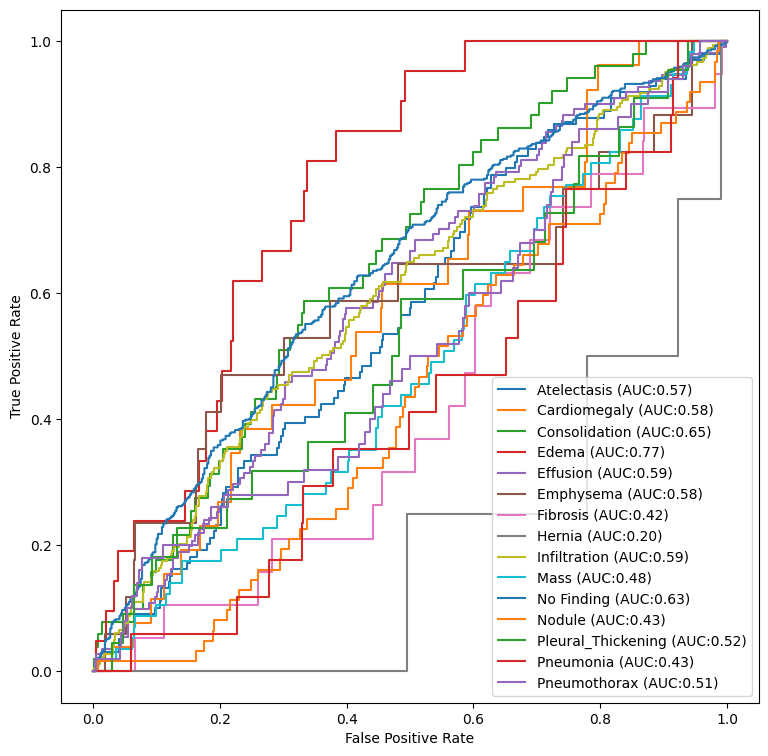

In [36]:
# ROC CURVE

from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y_densenet201[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [33]:
# EfficientNetB4

from keras.applications import efficientnet
from keras.models import Model

efficientnet_model = efficientnet.EfficientNetB4(input_shape = x_train.shape[1:],
                                      include_top = False,
                                      weights = None)
for layer in efficientnet_model.layers:
    layer.trainable = False # freezing

x = efficientnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(len(all_labels), activation = 'sigmoid')(x)

efficientnetv2_model = Model(inputs = efficientnet_model.input,
                         outputs = predictions)

efficientnetv2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 1)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 1)  3           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 1)  0           ['normalization[0][0]']    

In [34]:
efficientnetv2_model.compile(loss='binary_crossentropy',
               optimizer = 'adam',
               metrics=['binary_accuracy'])

hist_3 = efficientnetv2_model.fit(train_generation, verbose = 1, epochs=10, steps_per_epoch = 50, validation_data = (test_X, test_Y))

Epoch 1/10
50/50 [==============================] - 90s 1s/step - loss: 0.5174 - binary_accuracy: 0.9154 - val_loss: 0.2824 - val_binary_accuracy: 0.9208
Epoch 2/10
50/50 [==============================] - 73s 1s/step - loss: 0.2294 - binary_accuracy: 0.9226 - val_loss: 0.2203 - val_binary_accuracy: 0.9208
Epoch 3/10
50/50 [==============================] - 72s 1s/step - loss: 0.2130 - binary_accuracy: 0.9230 - val_loss: 0.2185 - val_binary_accuracy: 0.9208
Epoch 4/10
50/50 [==============================] - 72s 1s/step - loss: 0.2219 - binary_accuracy: 0.9189 - val_loss: 0.2183 - val_binary_accuracy: 0.9208
Epoch 5/10
50/50 [==============================] - 69s 1s/step - loss: 0.2233 - binary_accuracy: 0.9179 - val_loss: 0.2182 - val_binary_accuracy: 0.9208
Epoch 6/10
50/50 [==============================] - 71s 1s/step - loss: 0.2200 - binary_accuracy: 0.9191 - val_loss: 0.2183 - val_binary_accuracy: 0.9208
Epoch 7/10
50/50 [==============================] - 69s 1s/step - loss: 0.22

> > The result of the pretrained model efficientnetb4 did not meet the needed accuracy for the pretrained model, which is 95% accuracy.

In [37]:
pred_Y_efficientnetb4 = efficientnetv2_model.predict(test_X, batch_size = 32, verbose = True)

32/32 [==============================] - 15s 369ms/step


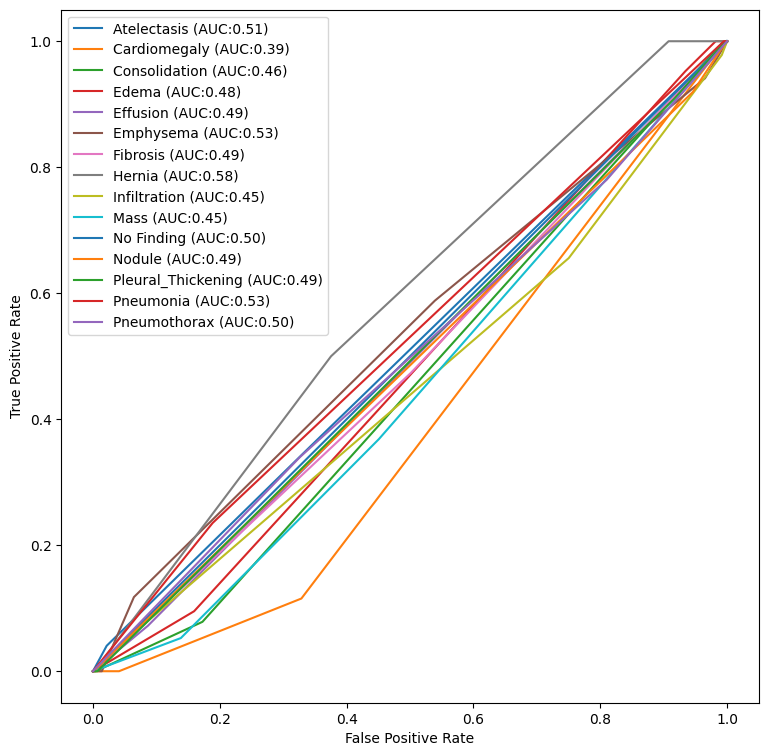

In [38]:
# ROC CURVE

from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y_efficientnetb4[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [39]:
# DenseNet121

from keras.applications import densenet
from keras.models import Model

densenet2_model = densenet.DenseNet121(input_shape = x_train.shape[1:],
                                      include_top = False,
                                      weights = None)
for layer in densenet_model.layers:
    layer.trainable = False # freezing

x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(len(all_labels), activation = 'sigmoid')(x)

densenet2v2_model = Model(inputs = densenet_model.input,
                         outputs = predictions)

densenet2v2_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  3136        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [40]:
densenet2v2_model.compile(loss='binary_crossentropy',
               optimizer = 'adam',
               metrics=['binary_accuracy'])

hist_4 = densenet2v2_model.fit(train_generation, verbose = 1, epochs= 10, steps_per_epoch = 50, validation_data = (test_X, test_Y))

Epoch 1/10
50/50 [==============================] - 93s 2s/step - loss: 0.3147 - binary_accuracy: 0.9079 - val_loss: 0.2199 - val_binary_accuracy: 0.9208
Epoch 2/10
50/50 [==============================] - 77s 2s/step - loss: 0.2160 - binary_accuracy: 0.9235 - val_loss: 0.2180 - val_binary_accuracy: 0.9208
Epoch 3/10
50/50 [==============================] - 82s 2s/step - loss: 0.2191 - binary_accuracy: 0.9203 - val_loss: 0.2185 - val_binary_accuracy: 0.9208
Epoch 4/10
50/50 [==============================] - 75s 1s/step - loss: 0.2174 - binary_accuracy: 0.9216 - val_loss: 0.2194 - val_binary_accuracy: 0.9208
Epoch 5/10
50/50 [==============================] - 78s 2s/step - loss: 0.2173 - binary_accuracy: 0.9217 - val_loss: 0.2192 - val_binary_accuracy: 0.9163
Epoch 6/10
50/50 [==============================] - 85s 2s/step - loss: 0.2165 - binary_accuracy: 0.9210 - val_loss: 0.2185 - val_binary_accuracy: 0.9223
Epoch 7/10
50/50 [==============================] - 77s 2s/step - loss: 0.22

> The result of the pretrained model densenet121 did not meet the needed accuracy for the pretrained model, which is 95% accuracy.

In [41]:
pred_Y_densenet121 = densenet2v2_model.predict(test_X, batch_size = 32, verbose = True)

32/32 [==============================] - 11s 245ms/step


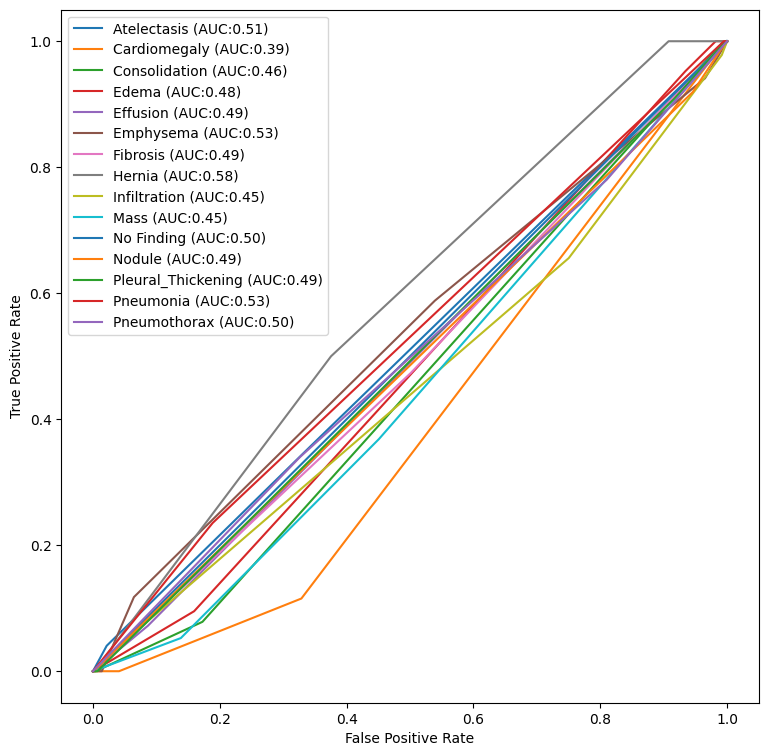

In [42]:
# ROC CURVE

from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y_efficientnetb4[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

> Throughout this skills exam, my skills and understanding in building a Convolutional Neural Network has improved a lot. Although majority of the objectives of the skills exam have not met, I was able to somehow improve my understanding in preprocessing, image generation, and building of the model. Doing this notebook is both fun and agonizing. Specially the training of the model, where time is the enemy. Overall, this activity helped me build my knowledge in building CNN models using python.